# Battery Aging Analysis Using NASA Dataset with Plotly on Kaggle
In this project, we analyze the NASA Battery Dataset within the Kaggle environment. The focus is on examining how key parameters—Battery Impedance, Estimated Electrolyte Resistance (Re), and Charge Transfer Resistance (Rct)—change progressively over multiple charge and discharge cycles as the battery undergoes aging.

In [2]:
import pandas as pd
from datetime import datetime

metadata_path = "cleaned_dataset/metadata.csv"
metadata_df = pd.read_csv(metadata_path)

impedance_metadata = metadata_df[metadata_df['type'] == 'impedance'][['start_time', 'Re', 'Rct', 'battery_id']]

impedance_metadata.head()

start_time                    Re  \
1   [2010.       7.      21.      16.      53.    ...   0.05605783343888099   
3                     [2010    7   21   20   31    5]   0.05319185850921101   
13  [2010.       7.      22.      17.       3.    ...   0.05963791501051059   
15        [2010.     7.    22.    20.    40.    25.5]   0.05512505361624278   
17  [2010.       7.      23.      11.      35.    ...  0.058878485312444453   

                    Rct battery_id  
1   0.20097016584458333      B0047  
3   0.16473399914864734      B0047  
13  0.21039872263834902      B0047  
15   0.1754882075917004      B0047  
17  0.19095687096090014      B0047

In [3]:
def parse_start_time(value):
    try:
        if isinstance(value, str):
            value = value.strip("[]").replace(",", "")
            components = [float(x) for x in value.split()]
            if len(components) == 6:
                year, month, day, hour, minute = map(int, components[:5])
                second = int(components[5])
                return datetime(year, month, day, hour, minute, second)
    except (ValueError, SyntaxError, TypeError):
        return pd.NaT
    return pd.NaT

impedance_metadata['start_time'] = impedance_metadata['start_time'].apply(parse_start_time)
impedance_metadata = impedance_metadata.dropna(subset=['start_time'])
impedance_metadata = impedance_metadata.sort_values(by='start_time')
impedance_metadata.head()

start_time                   Re                  Rct battery_id
5160 2008-04-18 20:55:29  0.04466870036616091  0.06945627304536996      B0005
5776 2008-04-18 20:55:29  0.03816813609946085  0.06158094574229446      B0007
4544 2008-04-18 20:55:29  0.06123359021000344   0.0785415394665875      B0006
4546 2008-04-18 22:39:16  0.06561684946388616   0.0886832084583472      B0006
5162 2008-04-18 22:39:16  0.04668700162486933  0.07627474098530587      B0005

### **Improved Visualization and Analysis Strategy**  

#### **Objective**  
The goal is to develop interactive and visually compelling plots to analyze battery aging trends, focusing on how **Electrolyte Resistance (Re)** and **Charge Transfer Resistance (Rct)** evolve over time.  

---
**Facet Plots: Battery-Specific Trends**  
   - Facet plots are employed to display **Re** trends over time for each individual battery in separate panels.  
   - This approach facilitates a more detailed, focused analysis of each battery’s performance and degradation behavior.  

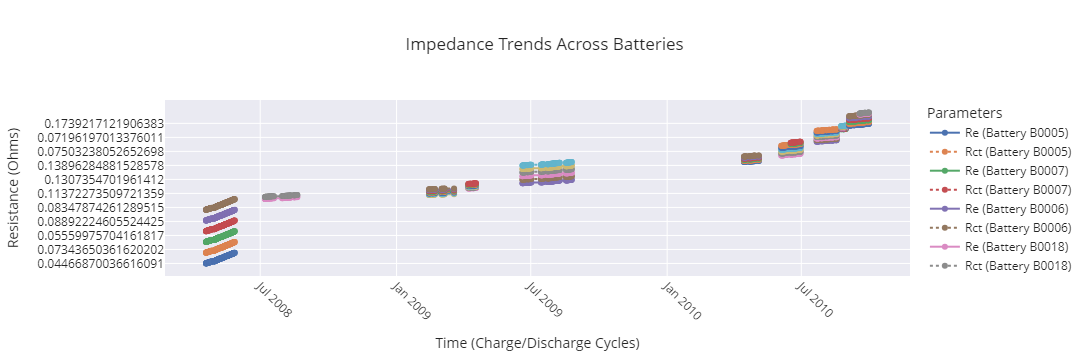

In [10]:
import plotly.graph_objects as go
import plotly.io as pio


def plot_impedance_trends(data):
    aggregated_fig = go.Figure()

    for battery_id in data['battery_id'].unique():
        battery_data = data[data['battery_id'] == battery_id]
        
        aggregated_fig.add_trace(go.Scatter(
            x=battery_data['start_time'],
            y=battery_data['Re'],
            mode='lines+markers',
            name=f'Re (Battery {battery_id})',
            line=dict(width=2),
            marker=dict(size=6)
        ))
        aggregated_fig.add_trace(go.Scatter(
            x=battery_data['start_time'],
            y=battery_data['Rct'],
            mode='lines+markers',
            name=f'Rct (Battery {battery_id})',
            line=dict(dash='dot', width=2),
            marker=dict(size=6)
        ))
    
    aggregated_fig.update_layout(
        title="Impedance Trends Across Batteries",
        xaxis_title="Time (Charge/Discharge Cycles)",
        yaxis_title="Resistance (Ohms)",
        xaxis=dict(showgrid=True, tickangle=45),
        yaxis=dict(showgrid=True),
        legend_title="Parameters",
        template="seaborn"
    )

    aggregated_fig.show()

plot_impedance_trends(impedance_metadata)

**Scatter Plot Matrix: Exploring Relationships**  
   - A scatter plot matrix visualizes the relationships between key variables, such as **Re** and **Rct**, for all batteries.  
   - This method is effective for uncovering correlations, anomalies, or outliers in the dataset.  

In [6]:
import plotly.express as px

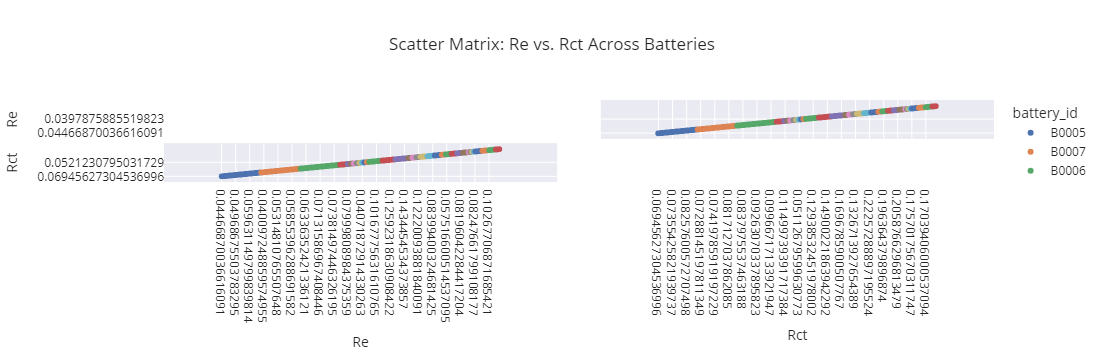

In [11]:
fig = px.scatter_matrix(
    impedance_metadata,
    dimensions=['Re', 'Rct'],
    color='battery_id',
    title="Scatter Matrix: Re vs. Rct Across Batteries",
    template="seaborn",
    height=800
)
fig.update_traces(diagonal_visible=False)
fig.show()

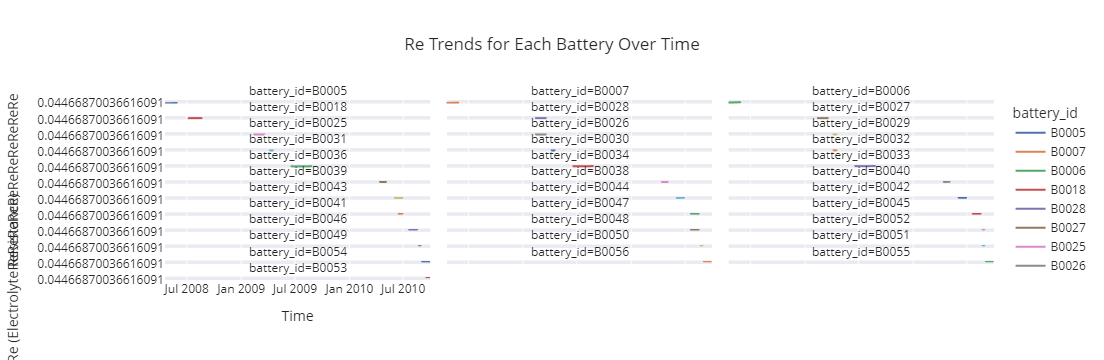

In [12]:
facet_data = impedance_metadata.copy()
facet_data['day'] = facet_data['start_time'].dt.date

fig = px.line(
    facet_data,
    x='start_time',
    y='Re',
    color='battery_id',
    facet_col='battery_id',
    facet_col_wrap=3,
    title="Re Trends for Each Battery Over Time",
    template="seaborn",
    height=1000
)
fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Re (Electrolyte Resistance)"
)
fig.show()

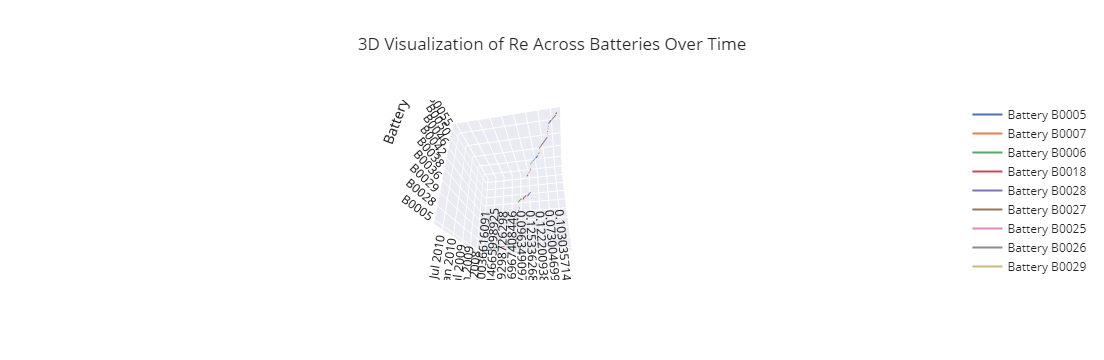

In [13]:
fig = go.Figure()

for battery_id in impedance_metadata['battery_id'].unique():
    battery_data = impedance_metadata[impedance_metadata['battery_id'] == battery_id]
    fig.add_trace(go.Scatter3d(
        x=battery_data['start_time'],
        y=battery_data['Re'],
        z=battery_data['battery_id'],
        mode='lines',
        name=f'Battery {battery_id}'
    ))

fig.update_layout(
    title="3D Visualization of Re Across Batteries Over Time",
    scene=dict(
        xaxis_title="Time",
        yaxis_title="Re (Electrolyte Resistance)",
        zaxis_title="Battery ID"
    ),
    template="seaborn",
    height=800
)
fig.show()

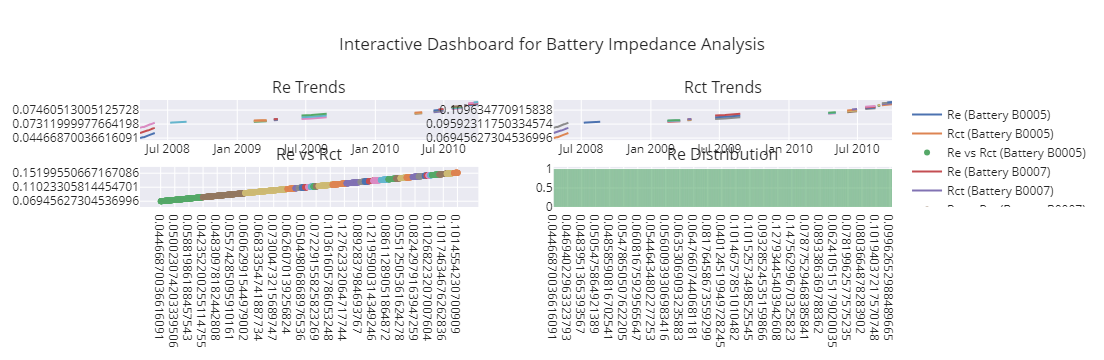

In [14]:
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Re Trends", "Rct Trends", "Re vs Rct", "Re Distribution"),
    specs=[[{}, {}], [{}, {}]]
)

for battery_id in impedance_metadata['battery_id'].unique():
    battery_data = impedance_metadata[impedance_metadata['battery_id'] == battery_id]
    fig.add_trace(go.Scatter(
        x=battery_data['start_time'],
        y=battery_data['Re'],
        mode='lines',
        name=f"Re (Battery {battery_id})"
    ), row=1, col=1)
    fig.add_trace(go.Scatter(
        x=battery_data['start_time'],
        y=battery_data['Rct'],
        mode='lines',
        name=f"Rct (Battery {battery_id})"
    ), row=1, col=2)
    fig.add_trace(go.Scatter(
        x=battery_data['Re'],
        y=battery_data['Rct'],
        mode='markers',
        name=f"Re vs Rct (Battery {battery_id})"
    ), row=2, col=1)

fig.add_trace(go.Histogram(
    x=impedance_metadata['Re'],
    name="Re Distribution"
), row=2, col=2)

fig.update_layout(
    title="Interactive Dashboard for Battery Impedance Analysis",
    template="seaborn",
    height=1000
)
fig.show()

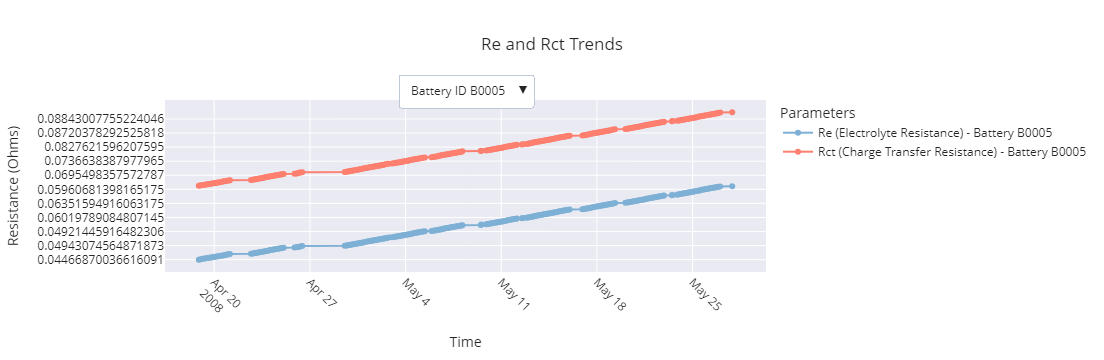

In [20]:
import plotly.graph_objects as go

def create_plot_with_dropdown(impedance_metadata):
    battery_ids = impedance_metadata['battery_id'].unique()
    
    fig = go.Figure()

    for battery_id in battery_ids:
        battery_data = impedance_metadata[impedance_metadata['battery_id'] == battery_id]
        fig.add_trace(go.Scatter(
            x=battery_data['start_time'],
            y=battery_data['Re'],
            mode='lines+markers',
            name=f'Re (Electrolyte Resistance) - Battery {battery_id}',
            visible=False, 
            line=dict(color='#7eb0d5')
        ))
        fig.add_trace(go.Scatter(
            x=battery_data['start_time'],
            y=battery_data['Rct'],
            mode='lines+markers',
            name=f'Rct (Charge Transfer Resistance) - Battery {battery_id}',
            visible=False,  
            line=dict(color='#fd7f6f')
        ))


    for i in range(2):  
        fig.data[i].visible = True

    dropdown_options = []
    for i, battery_id in enumerate(battery_ids):
        visible_traces = [False] * len(fig.data)
        visible_traces[2 * i] = True  
        visible_traces[2 * i + 1] = True 
        dropdown_options.append(
            dict(label=f"Battery ID {battery_id}",
                 method="update",
                 args=[{"visible": visible_traces}])
        )

    fig.update_layout(
        updatemenus=[
            dict(
                buttons=dropdown_options,
                direction="down",
                showactive=True,
                x=0.5,
                y=1.15,
                xanchor="center",
                yanchor="top"
            )
        ],
        title="Re and Rct Trends",
        xaxis_title="Time",
        yaxis_title="Resistance (Ohms)",
        xaxis=dict(showgrid=True, tickangle=45),
        yaxis=dict(showgrid=True),
        legend_title="Parameters",
        template="seaborn"
    )
    
    fig.show()

create_plot_with_dropdown(impedance_metadata)

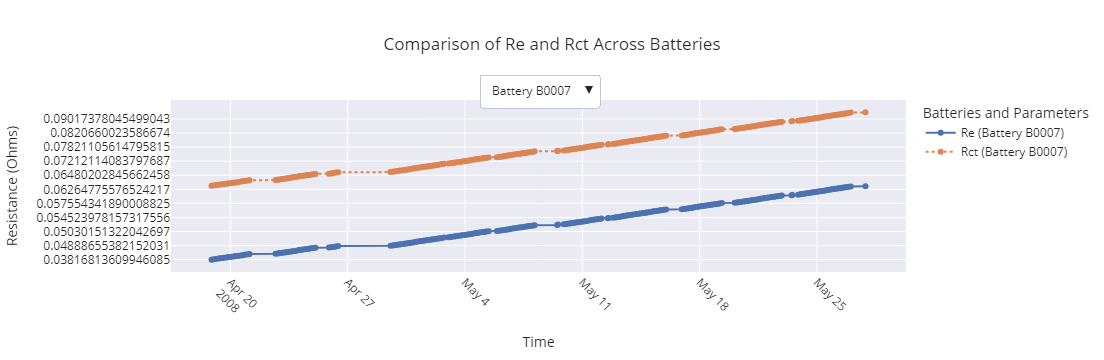

In [19]:
import plotly.graph_objects as go

def create_comparison_plot(impedance_metadata):
    battery_ids = impedance_metadata['battery_id'].unique()
    fig = go.Figure()

    for battery_id in battery_ids:
        battery_data = impedance_metadata[impedance_metadata['battery_id'] == battery_id]
        fig.add_trace(go.Scatter(
            x=battery_data['start_time'],
            y=battery_data['Re'],
            mode='lines+markers',
            name=f'Re (Battery {battery_id})',
            visible=(battery_id == battery_ids[0]),
            line=dict(width=2)
        ))
        fig.add_trace(go.Scatter(
            x=battery_data['start_time'],
            y=battery_data['Rct'],
            mode='lines+markers',
            name=f'Rct (Battery {battery_id})',
            visible=(battery_id == battery_ids[0]),
            line=dict(dash='dot', width=2)
        ))

    visibility_template = [False] * len(fig.data)
    dropdown_options = []

    for battery_id in battery_ids:
        visible_traces = visibility_template.copy()
        idx = list(battery_ids).index(battery_id)
        visible_traces[2 * idx] = True
        visible_traces[2 * idx + 1] = True
        dropdown_options.append(
            dict(label=f"Battery {battery_id}",
                 method="update",
                 args=[{"visible": visible_traces}])
        )

    fig.update_layout(
        updatemenus=[
            dict(
                type="dropdown",
                buttons=dropdown_options,
                direction="down",
                showactive=True,
                x=0.5,
                y=1.15,
                xanchor="center",
                yanchor="top"
            )
        ],
        title="Comparison of Re and Rct Across Batteries",
        xaxis_title="Time",
        yaxis_title="Resistance (Ohms)",
        xaxis=dict(showgrid=True, tickangle=45),
        yaxis=dict(showgrid=True),
        legend_title="Batteries and Parameters",
        template="seaborn"
    )

    fig.show()

create_comparison_plot(impedance_metadata)

**Heatmap: Identifying Resistance Patterns Over Time**  
   - A heatmap is used to illustrate the behavior of **Re** (electrolyte resistance) across all batteries over time.  
   - This visualization helps identify overarching trends and spot any sudden or significant changes. 

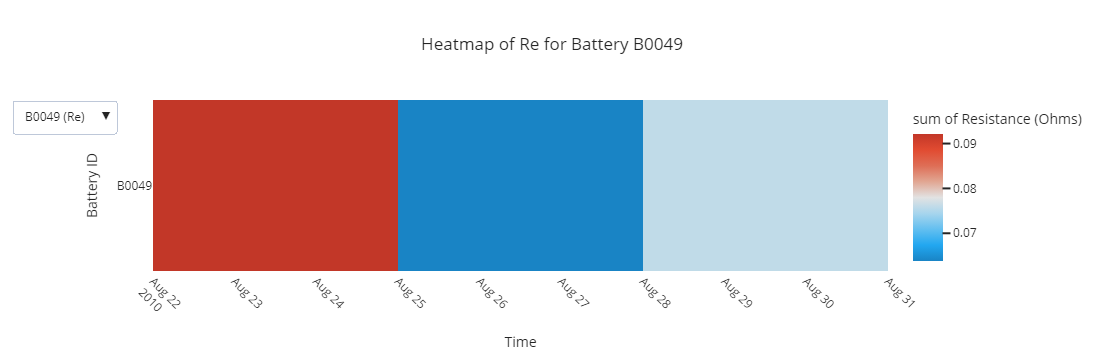

In [26]:
import plotly.express as px
import warnings

def plot_combined_heatmap_with_dropdown():
    warnings.filterwarnings("ignore")  

    battery_options = impedance_metadata['battery_id'].unique()
    initial_battery = battery_options[0]

    def get_filtered_data(battery, parameter):
        data = impedance_metadata[impedance_metadata['battery_id'] == battery]
        data['time'] = data['start_time'].dt.strftime('%Y-%m-%d %H:%M:%S')
        return data

    # Define custom diverging color scale
    custom_colors = ["#1984c5", "#22a7f0", "#63bff0", "#a7d5ed", "#e2e2e2", "#e1a692", "#de6e56", "#e14b31", "#c23728"]

    fig = px.density_heatmap(
        get_filtered_data(initial_battery, 'Re'),
        x='time',
        y='battery_id',
        z='Re',
        color_continuous_scale=custom_colors,  # Apply the custom color scale here
        title="Heatmap of Re Across Batteries Over Time",
        labels={'time': 'Time', 'battery_id': 'Battery ID', 'Re': 'Resistance (Ohms)'},
        template="seaborn"
    )

    fig.update_layout(
        xaxis=dict(tickangle=45),
        xaxis_title="Time",
        yaxis_title="Battery ID",
        updatemenus=[
            {
                "buttons": [
                    {
                        "label": f"{battery} (Re)",
                        "method": "update",
                        "args": [
                            {
                                "x": [get_filtered_data(battery, 'Re')['time']],
                                "y": [get_filtered_data(battery, 'Re')['battery_id']],
                                "z": [get_filtered_data(battery, 'Re')['Re']],
                            },
                            {"title": f"Heatmap of Re for Battery {battery}"}
                        ]
                    } for battery in battery_options
                ]
                + [
                    {
                        "label": f"{battery} (Rct)",
                        "method": "update",
                        "args": [
                            {
                                "x": [get_filtered_data(battery, 'Rct')['time']],
                                "y": [get_filtered_data(battery, 'Rct')['battery_id']],
                                "z": [get_filtered_data(battery, 'Rct')['Rct']],
                            },
                            {"title": f"Heatmap of Rct for Battery {battery}"}
                        ]
                    } for battery in battery_options
                ],
                "direction": "down",
                "showactive": True,
            }
        ]
    )

    fig.show()
    warnings.resetwarnings()  # Re-enable warnings after the function is executed

plot_combined_heatmap_with_dropdown()


#### **Insights**  

- **Heatmap**: Provides a high-level overview of resistance trends over time, enabling the detection of global patterns or abrupt shifts.  
- **Scatter Plot Matrix**: Highlights relationships between **Re** and **Rct**, making it easier to identify correlated trends or anomalies.  
- **Facet Plots**: Offer a granular view of individual battery performance, revealing detailed degradation patterns across charge/discharge cycles.  

---

In [23]:
impedance_metadata['Re'] = pd.to_numeric(impedance_metadata['Re'], errors='coerce')
impedance_metadata['Rct'] = pd.to_numeric(impedance_metadata['Rct'], errors='coerce')

summary_stats = impedance_metadata.groupby('battery_id').agg(
    Re_initial=('Re', 'first'),
    Re_final=('Re', 'last'),
    Rct_initial=('Rct', 'first'),
    Rct_final=('Rct', 'last')
)

summary_stats['Re_change'] = summary_stats['Re_final'] - summary_stats['Re_initial']
summary_stats['Rct_change'] = summary_stats['Rct_final'] - summary_stats['Rct_initial']

summary_stats.reset_index()

battery_id  Re_initial     Re_final  Rct_initial    Rct_final    Re_change  \
0       B0005    0.044669     0.050036     0.069456     0.074792     0.005367   
1       B0006    0.061234     0.073589     0.078542     0.099995     0.012356   
2       B0007    0.038168     0.067143     0.061581     0.093314     0.028975   
3       B0018    0.065158     0.066069     0.095554     0.088959     0.000910   
4       B0025    0.050642     0.049661     0.105922     0.082445    -0.000981   
5       B0026    0.092718     0.090389     0.137872     0.117676    -0.002329   
6       B0027    0.090840     0.099692     0.139167     0.124854     0.008852   
7       B0028    0.081411     0.079702     0.134353     0.113723    -0.001709   
8       B0029    0.028340     0.028169     0.044702     0.041196    -0.000172   
9       B0030    0.063418     0.064615     0.077259     0.075343     0.001197   
10      B0031    0.040125     0.040724     0.053763     0.050652     0.000600   
11      B0032    0.070665     0.072333     0.079450     0.079436     0.001668   
12      B0033    0.103694     0.085790     0.141873     0.112924    -0.017904   
13      B0034    0.125574     0.127815     0.157806     0.152955     0.002241   
14      B0036    0.105458     0.104522     0.148769     0.128982    -0.000936   
15      B0038    0.107412     0.156443     0.194225     0.168887     0.049031   
16      B0039    0.104138     0.106528     0.126577     0.118190     0.002391   
17      B0040    0.118795     0.138517     0.147572     0.149890     0.019721   
18      B0041    0.053543     0.057189     0.185902     0.194129     0.003646   
19      B0042    0.075864     0.079037     0.128331     0.209457     0.003173   
20      B0043    0.069534     0.078207     0.112706     0.217416     0.008673   
21      B0044    0.080249     0.084694     0.144593     0.230488     0.004445   
22      B0045    0.072628     0.073910     0.245653     0.238779     0.001282   
23      B0046    0.091945     0.080832     0.187072     0.211463    -0.011114   
24      B0047    0.056058     0.073005     0.200970     0.221714     0.016947   
25      B0048    0.077991     0.080527     0.239749     0.225725     0.002536   
26      B0049    0.048745     0.075917     0.161764     0.106822     0.027171   
27      B0050    0.084580 -5470.683829     0.212442  2784.356689 -5470.768410   
28      B0051    0.071369     0.080366     0.218351     0.151889     0.008997   
29      B0052    0.078448 -4050.754453     0.190476  3322.117107 -4050.832901   
30      B0053    0.100902     0.101951     0.154780     0.165885     0.001049   
31      B0054    0.107292     0.101505     0.221870     0.174274    -0.005787   
32      B0055    0.101578     0.096809     0.234717     0.154897    -0.004769   
33      B0056    0.108860     0.102677     0.242352     0.170394    -0.006183   

     Rct_change  
0      0.005336  
1      0.021453  
2      0.031733  
3     -0.006595  
4     -0.023477  
5     -0.020197  
6     -0.014312  
7     -0.020630  
8     -0.003507  
9     -0.001916  
10    -0.003111  
11    -0.000014  
12    -0.028949  
13    -0.004851  
14    -0.019787  
15    -0.025339  
16    -0.008387  
17     0.002318  
18     0.008227  
19     0.081126  
20     0.104710  
21     0.085896  
22    -0.006873  
23     0.024391  
24     0.020744  
25    -0.014024  
26    -0.054942  
27  2784.144246  
28    -0.066462  
29  3321.926630  
30     0.011105  
31    -0.047596  
32    -0.079819  
33    -0.071958

#### **References**  
The following resources were utilized for research and guidance during the analysis:  
1. [How to Visualize Battery Data](https://peaxy.net/how-to-visualize-battery-data/)  
2. [Data Analysis and Feature Extraction for Battery Raw Cycling Data](https://www.mathworks.com/help/predmaint/ug/data-analysis-and-feature-extraction-for-battery-raw-cycling-data.html)  